In [1]:
# importing relevant libraries
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
import pandas as pd
import numpy as np
import sqlalchemy as sa
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, cross_validation, grid_search
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from scipy import interp
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import os
import functools

# Turn off pandas chained assignment warning
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 999

E:\Program Files\Anaconda3\envs\crookshanks\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\Program Files\Anaconda3\envs\crookshanks\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 1. CLEAN PLI, PITT & TAX DATA

In [31]:
# create directory paths for opening files
# curr_path = ''
curr_path = os.path.dirname(os.path.realpath("fs_grid.ipynb"))
dataset_path = os.path.join(curr_path, "datasets/")
inter_path = os.path.join(curr_path,"interResults/")
png_path = os.path.join(curr_path,"images/")

# read in data
# Reading plidata
plidata = pd.read_csv(os.path.join(dataset_path, "pli.csv"), encoding='utf-8', dtype={'STREET_NUM': 'str', 'STREET_NAME': 'str'}, low_memory=False)
# Reading city of Pittsburgh dataset
pittdata = pd.read_csv(os.path.join(dataset_path, "pittdata.csv"), encoding="ISO-8859-1", dtype={'PROPERTYADDRESS': 'str', 'PROPERTYHOUSENUM': 'str', 'CLASSDESC': 'str'}, low_memory=False)
# Reading tax data
taxdata = pd.read_csv("./datasets/tax.csv", encoding='utf-8')
#read parcel data (matches parcels to census tract and block group
parcel = pd.read_csv(os.path.join(dataset_path, "parcels.csv"), encoding='utf-8')
#read ACS data
acs_data = ['income.csv','occupancy.csv','yearBuilt.csv','yearMovedIn.csv']
def clean_acs(df):
    #Use descriptive names in first row
    df = df.drop(0)
    df = df.drop(['Estimate!!Total','state','county'], axis=1)
    return df
acs_data = map(lambda x: os.path.join(dataset_path, x), acs_data)
acs_data = map(pd.read_csv, acs_data)
acs_data = map(clean_acs, acs_data)
#Merge datasets together
acs_data_combined = functools.reduce(lambda x,y:x.merge(y, how='outer', on=['tract','block group']), acs_data)
acs_data_combined['tract']=pd.to_numeric(acs_data_combined.tract)
acs_data_combined['block group'] = pd.to_numeric(acs_data_combined['block group'])

# cleaning pitt dataset
# removing all properties outside Pittsburgh, Wilkinsburg, and Ingram
pittdata = pittdata[(pittdata.PROPERTYCITY == 'PITTSBURGH')]  # & (pittdata.PROPERTYCITY == 'WILKINSBURG') & (pittdata.PROPERTYCITY == 'INGRAM')]
# include only residential data
pittdata = pittdata[pittdata['CLASSDESC'] == 'RESIDENTIAL']
address_parcels = pittdata[['PARID','PROPERTYADDRESS','PROPERTYHOUSENUM']].drop_duplicates()
pittdata = pittdata[pittdata['PROPERTYHOUSENUM'] != '0']
pittdata = pittdata[pittdata['PROPERTYADDRESS'] != '']
# dropping columns with less than 15% data
pittdata = pittdata.dropna(thresh=4000, axis=1)
pittdata = pittdata.rename(columns={pittdata.columns[0]: 'PARID'})
# pick out necessary columns
pittdata = pittdata[['PARID','PROPERTYHOUSENUM','PROPERTYADDRESS','MUNIDESC','SCHOOLDESC','NEIGHCODE',
                     'TAXDESC','OWNERDESC','USEDESC','LOTAREA','SALEPRICE','FAIRMARKETBUILDING','FAIRMARKETLAND']]
pittdata = pittdata.drop_duplicates()

# cleaning pli dataset
# removing extra whitespaces
plidata['STREET_NAME'] = plidata['STREET_NAME'].str.strip()
plidata['STREET_NUM'] = plidata['STREET_NUM'].str.strip()
# include only residential data
plidata = pd.merge(plidata, address_parcels[['PARID']], how='inner',left_on=['PARCEL'], right_on=['PARID'])
# pick out necessary columns
plidata=plidata[['PARCEL', 'INSPECTION_DATE', 'INSPECTION_RESULT', 'VIOLATION']]
# converting to datetime
plidata.INSPECTION_DATE = pd.to_datetime(plidata.INSPECTION_DATE)
plidata['violation_year'] = plidata['INSPECTION_DATE'].map(lambda x: x.year)
plidata = plidata.drop_duplicates()

# cleaning tax dataset
# removing all properties outside Pittsburgh, Wilkinsburg, and Ingram
taxdata = taxdata[(taxdata.municipality == 'Pittsburgh')]  # & (tax.municipality == 'Wilkinsburg Boro') & (tax.municipality == 'Ingram Boro')]
taxdata = taxdata.dropna(subset=['pin', 'tax_year', 'lien_description', 'amount', 'satisfied'])
# include only residential data
taxdata = pd.merge(taxdata, address_parcels[['PARID']], how='inner', left_on=['pin'], right_on=['PARID'])
# pick out necessary columns
taxdata = taxdata[['pin', 'filing_date', 'tax_year', 'lien_description', 'amount','satisfied']]
taxdata.filing_date = pd.to_datetime(taxdata.filing_date)
taxdata.tax_year=taxdata['tax_year'].apply(lambda x: date(x,12,31))
taxdata.tax_year = pd.to_datetime(taxdata.tax_year)
taxdata = taxdata.drop_duplicates()

# cleaning parcel dataset
# keep only parcel, tract, and block group
parcel = parcel[(parcel.geo_name_cousub == 'Pittsburgh city')]
parcel_blocks = parcel[['PIN', 'TRACTCE10', 'BLOCKCE10']]
#get first digit of block, convert to int
parcel_blocks['BLOCKCE10'] = parcel_blocks['BLOCKCE10'].astype(str).str[0].astype(int)
#ignore bad parcels
parcel_blocks = parcel_blocks[parcel_blocks['PIN'] != ' ']
parcel_blocks = parcel_blocks[parcel_blocks['PIN'] != 'COMMON GROUND']
parcel_blocks = parcel_blocks[~parcel_blocks['PIN'].str.match('.*County')]
parcel_blocks=parcel_blocks.drop_duplicates()

E:\Program Files\Anaconda3\envs\crookshanks\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### 1.1 Aggregate pittdata to census block, then merge with acs data

In [36]:
pittdata_blocks=pd.merge(pittdata, parcel_blocks, how='left', left_on=['PARID'], right_on=['PIN'])
#drop extra columns
pittdata_blocks = pittdata_blocks.drop(['PARID','PIN','PROPERTYHOUSENUM','PROPERTYADDRESS'], axis=1)


#group by blocks
grouped = pittdata_blocks.groupby(['TRACTCE10','BLOCKCE10'])
#change the '-DESC' columns to the most common in each group (block)
#change the other columns to the mean
max_count = lambda x:x.value_counts().index[0]
pittdata_blocks = grouped.agg({
    'MUNIDESC':max_count,'SCHOOLDESC':max_count,'NEIGHCODE':max_count,
    'TAXDESC':max_count,'OWNERDESC':max_count,'USEDESC':max_count,'LOTAREA':np.mean,
    'SALEPRICE':np.mean,'FAIRMARKETBUILDING':np.mean,'FAIRMARKETLAND':np.mean
})
#reset index to columns
pittdata_blocks = pittdata_blocks.reset_index(level=[0,1])
#merge pittdata with acs
pittacs = pd.merge(pittdata_blocks, acs_data_combined, how='inner', left_on=['BLOCKCE10','TRACTCE10'],right_on=['block group','tract'])
pittacs = pittacs.drop(['tract','block group'],axis=1)
# keep a copy of blocks and tracts
blocks = pittacs[['TRACTCE10','BLOCKCE10']].drop_duplicates()

#### 1.2 merge plidata with census block

In [37]:
#group by blocks
plidata_blocks = pd.merge(plidata, parcel_blocks, how='left', left_on=['PARCEL'], right_on=['PIN'])
#drop extra columns
plidata_blocks = plidata_blocks.drop(['PARCEL','PIN'], axis=1)
plidata_blocks=plidata_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])

#### 1.3 Aggregate taxdata to census block¶

In [38]:
# group by blocks
taxdata_blocks = pd.merge(taxdata,parcel_blocks, how='left', left_on=['pin'], right_on=['PIN'])
taxdata_blocks = taxdata_blocks.drop(['pin','PIN'],axis=1)
taxdata_blocks = taxdata_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])

### 2. Clean fire incident data

In [39]:
# loading fire incidents csvs
fire_pre14 = pd.read_csv(os.path.join(dataset_path, "Fire_Incidents_Pre14.csv"), encoding='latin-1', dtype={'street': 'str', 'number': 'str'}, low_memory=False)
fire_new = pd.read_csv(os.path.join(dataset_path, "Fire_Incidents_New.csv"), encoding='utf-8', dtype={'street': 'str', 'number': 'str'}, low_memory=False)

# cleaning columns of fire_pre14
fire_pre14['full.code'] = fire_pre14['full.code'].str.replace('  -', ' -')
fire_pre14['st_type'] = fire_pre14['st_type'].str.strip()
fire_pre14['street'] = fire_pre14['street'].str.strip()
fire_pre14['number'] = fire_pre14['number'].str.strip()
fire_pre14['st_type'] = fire_pre14['st_type'].str.replace('AV', 'AVE')
fire_pre14['street'] = fire_pre14['street'].str.strip() + ' ' + fire_pre14['st_type'].str.strip()

# drop irrelevant columns
pre14_drop = ['Unnamed: 0','PRIMARY_UNIT', 'MAP_PAGE', 'alm_dttm', 'arv_dttm', 'XCOORD', 
              'YCOORD','inci_id', 'inci_type', 'alarms', 'st_prefix',
              'st_suffix', 'st_type', 'CALL_NO','descript','ï..AGENCY']
for col in pre14_drop:
      del fire_pre14[col]


post14_drop = ['alm_dttm', 'arv_dttm', 'XCOORD', 'YCOORD', 'alarms', 
               'inci_type', 'CALL_NO','descript']
for col in post14_drop:
      del fire_new[col]

# joining both the fire incidents file together
fire_new = fire_new.append(fire_pre14, ignore_index=True)
fire_new = fire_new[fire_new['full.code'].str.strip() != '540 - Animal problem, Other']
fire_new = fire_new[fire_new['full.code'].str.strip() != '5532 - Public Education (Station Visit)']
fire_new = fire_new[fire_new['full.code'].str.strip() != '353 - Removal of victim(s) from stalled elevator']

# correcting problems with the street column
fire_new['street'] = fire_new['street'].replace(to_replace=', PGH', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace=', P', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace=',', value='', regex=True)
fire_new['street'] = fire_new['street'].replace(to_replace='#.*', value='', regex=True)
fire_new['street'] = fire_new['street'].str.strip()
fire_new['number'] = fire_new['number'].str.strip()

# converting to date time and extracting year
fireDate, fireTime = fire_new['CALL_CREATED_DATE'].str.split(' ', 1).str
fire_new['CALL_CREATED_DATE'] = fireDate
fire_new['CALL_CREATED_DATE'] = pd.to_datetime(fire_new['CALL_CREATED_DATE'])
fire_new['fire_year'] = fire_new['CALL_CREATED_DATE'].map(lambda x: x.year)

# removing all codes with less than 20 occurences
for col, val in fire_new['full.code'].value_counts().iteritems():
    if val < 20 and col[0] != '1':
        fire_new = fire_new[fire_new['full.code'] != col]

#Split street column when there are 2 streets
street_split = fire_new['street'].str.split('/')
fire_new['street'] = street_split.map(lambda x:x[0])
fire_new = fire_new.dropna(subset=['CALL_CREATED_DATE'])
fire_new = fire_new.drop_duplicates()

#### 2.1 merge fire incident to census block

In [40]:
# convert from addresses to parcels
fire_parcel = pd.merge(fire_new, address_parcels, how='inner',
                        left_on=['street','number'], right_on=['PROPERTYADDRESS','PROPERTYHOUSENUM'])
# convert from parcels to census blocks
fire_blocks = pd.merge(fire_parcel, parcel_blocks, how='left',left_on=['PARID'], right_on=['PIN'])
#drop extra columns
fire_blocks=fire_blocks.drop(['number','street','PARID','PROPERTYADDRESS',
                              'PROPERTYHOUSENUM','PIN', 'Unnamed: 0',
                              'st_prefix', 'st_suffix', 'st_type',
                              'prop_use_code','response_time',
                              'CALL_TYPE_FINAL', 'COUNCIL', 'NEIGHBORHOOD',
                              'PRIMARY_UNIT','fire_year','prop_use_descript'],axis=1)
#drop data without block or tract (this drops non-residential data)
fire_blocks = fire_blocks.dropna(subset=['TRACTCE10','BLOCKCE10'])
# dropping columns with less than 15% data
fire_blocks = fire_blocks.dropna(thresh=len(fire_blocks)*0.15, axis=1)
fire_blocks = fire_blocks.drop_duplicates()

### 3 Join four datasets together

#### 3.1 joining dynamic data with fire incidents

In [41]:
# making the fire column with all type 100s as fires and map it to 0 or 1
fire_blocks['fire'] = fire_blocks['full.code'].astype(str).map(lambda x: 1 if x[0]=='1' else 0)
# keep non-fire incidents as features
nonfire_incidents = fire_blocks[fire_blocks['fire'] != 1]
nonfire_incidents = nonfire_incidents[['CALL_CREATED_DATE','full.code','TRACTCE10', 'BLOCKCE10']]
fire_blocks.drop('full.code',axis=1,inplace=True)


# group by every certain period of time
# reason for setting period to year: tax data is based on year
period = 'A'
fire_groups = fire_blocks.groupby(pd.Grouper(key='CALL_CREATED_DATE', freq=period))
nonfire_groups = nonfire_incidents.groupby(pd.Grouper(key='CALL_CREATED_DATE', freq=period))
plidata_groups = plidata_blocks.groupby(pd.Grouper(key='INSPECTION_DATE', freq=period))
taxdata_groups = taxdata_blocks.groupby(pd.Grouper(key='tax_year', freq=period))

# get the date of the earliest fire in each block in each year
block_fire_dates = fire_groups.apply(lambda x:x.groupby(['TRACTCE10','BLOCKCE10']).apply(lambda x:x[x['fire']==1].min()))

# then group fire by census blocks
def groupByBlock(df,categoricals, method):
    dummies=[pd.get_dummies(df[feature]) for feature in categoricals]
    df = pd.concat([df]+dummies,axis=1)
    df.drop(categoricals,axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10'])
    if method == 'max':
        df_grouped=df_grouped.max()
    if method == 'sum':
        df_grouped=df_grouped.sum()
    return df_grouped
fire_divided = fire_groups.apply(groupByBlock,categoricals=[],method='max')
fire_divided.drop('CALL_CREATED_DATE',axis=1,inplace=True)
fire_divided=fire_divided.reset_index()
fire_divided=fire_divided.fillna(0)


# group nonfire incidents by census blocks
def groupByBlockNonfire(df, categoricals, method):
    # only keep data that occurred before the fire
    year = df['CALL_CREATED_DATE'].iloc[0].year
    df = pd.merge(df, block_fire_dates[block_fire_dates['CALL_CREATED_DATE'].dt.year == year], how='left',
                  on=['TRACTCE10', 'BLOCKCE10'], suffixes=['', '_F'])
    df['CALL_CREATED_DATE_F'] = df['CALL_CREATED_DATE_F'].fillna(pd.to_datetime('12-31-' + str(year)))
    df = df[df['CALL_CREATED_DATE'] <= df['CALL_CREATED_DATE_F']]
    df = df.drop(['CALL_CREATED_DATE_F', 'fire'], axis=1)

    dummies = [pd.get_dummies(df[feature]) for feature in categoricals]
    df = pd.concat([df] + dummies, axis=1)
    df.drop(categoricals, axis=1, inplace=True)
    df = pd.merge(df, blocks, how='right', on=['TRACTCE10', 'BLOCKCE10'])
    df_grouped = df.groupby(['TRACTCE10', 'BLOCKCE10'])
    if method == 'max':
        df_grouped = df_grouped.max()
    if method == 'sum':
        df_grouped = df_grouped.sum()
    return df_grouped

nonfire_divided = nonfire_groups.apply(groupByBlockNonfire,categoricals=['full.code'],method='sum')
nonfire_divided=nonfire_divided.reset_index()
nonfire_divided=nonfire_divided.fillna(0)


# group pli incidents by census blocks
def groupByBlock_pli(df):
    # only keep data that occurred before the fire
    year = df['INSPECTION_DATE'].iloc[0].year
    df = pd.merge(df, block_fire_dates[block_fire_dates['CALL_CREATED_DATE'].dt.year == year], how='left',
                  on=['TRACTCE10', 'BLOCKCE10'])
    df['CALL_CREATED_DATE'] = df['CALL_CREATED_DATE'].fillna(pd.to_datetime('12-31-' + str(year)))
    df = df[df['INSPECTION_DATE'] <= df['CALL_CREATED_DATE']]
    df = df.drop(['CALL_CREATED_DATE', 'fire'], axis=1)
    
    INSPECTION_RESULT_dummies=pd.get_dummies(df['INSPECTION_RESULT'])
    VIOLATION_dummies=df['VIOLATION'].str.get_dummies(sep=' :: ')
    df = pd.concat([df,INSPECTION_RESULT_dummies,VIOLATION_dummies],axis=1)
    df.drop(['INSPECTION_RESULT','VIOLATION','violation_year'],axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10']).sum()
    return df_grouped
pli_divided=plidata_groups.apply(groupByBlock_pli)
pli_divided=pli_divided.reset_index()
pli_divided=pli_divided.fillna(0)


# group tax data by census blocks
def groupByBlock_tax(df):
    tax_dummies=pd.get_dummies(df['lien_description'])
    df = pd.concat([df,tax_dummies],axis=1)
    df.drop(['lien_description'],axis=1,inplace=True)
    df = pd.merge(df, blocks, how='right',on=['TRACTCE10','BLOCKCE10'])
    df_grouped=df.groupby(['TRACTCE10','BLOCKCE10']).sum()
    return df_grouped

tax_divided=taxdata_groups.apply(groupByBlock,categoricals=['lien_description'],method='sum')
tax_divided=tax_divided.reset_index()
tax_divided=tax_divided.fillna(0)


# join fire, nonfire, pli, tax data together
fire_nonfire = pd.merge(fire_divided,nonfire_divided,how='outer',
                        on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli = pd.merge(fire_nonfire,pli_divided,how='outer',
                           left_on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],
                           right_on=['INSPECTION_DATE','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli_tax = pd.merge(fire_nonfire_pli,tax_divided,how='outer',
                               left_on=['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],
                               right_on=['tax_year','TRACTCE10','BLOCKCE10'])
fire_nonfire_pli_tax['CALL_CREATED_DATE']=fire_nonfire_pli_tax['CALL_CREATED_DATE'].fillna(fire_nonfire_pli_tax['CALL_CREATED_DATE'])
fire_nonfire_pli_tax.drop(['INSPECTION_DATE','tax_year'],axis=1,inplace=True)


# drop columns with less than thresold% data
threshold=0.0001
s=fire_nonfire_pli_tax.sum()
drop_columns=s[s<len(fire_nonfire_pli_tax)*threshold].index
fire_nonfire_pli_tax.drop(drop_columns,axis=1,inplace=True)

#### 3.2 Join with static data

In [42]:
# join with pitt_blocks
combined = pd.merge(fire_nonfire_pli_tax,pittacs,
                    how='left',on=['TRACTCE10','BLOCKCE10'])
features = ['SCHOOLDESC', 'OWNERDESC', 'MUNIDESC', 'NEIGHCODE','TAXDESC', 'USEDESC']
dummies= [pd.get_dummies(combined[feature]) for feature in features]
encoded_combined=pd.concat([combined]+dummies,axis=1)
encoded_combined.drop(features,axis=1,inplace=True)
encoded_combined=encoded_combined.dropna(subset=['CALL_CREATED_DATE'])
encoded_combined = encoded_combined.drop_duplicates()
encoded_combined=encoded_combined.fillna(0)
encoded_combined = encoded_combined[encoded_combined.CALL_CREATED_DATE <= '2017-12-31']

### 4 Split data into training set, validation set and test set

In [43]:
cutoffdate = '2016-12-31'
val_cutoffdate = '2015-12-31'

# training set, contains everything before 2015-12-31
traindata = encoded_combined[encoded_combined.CALL_CREATED_DATE <= val_cutoffdate]
traindata.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],axis=1,inplace=True)
traindata.fillna(0)
columns=np.array(traindata.columns)
X_train=np.array(traindata.drop(['fire'],axis=1))
y_train=np.array(traindata['fire'])

# validation set, contains data between 2016-1-1 and 2016-12-31
valdata = encoded_combined[(encoded_combined.CALL_CREATED_DATE > val_cutoffdate) & 
                           (encoded_combined.CALL_CREATED_DATE <= cutoffdate)]
valdata.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],axis=1,inplace=True)
valdata.fillna(0)
X_val=np.array(valdata.drop(['fire'],axis=1))
y_val=np.array(valdata['fire'])

#test set, contains data between 2017-1-1 and 2017-12-31
testdata = encoded_combined[encoded_combined.CALL_CREATED_DATE > cutoffdate]
testdata.drop(['CALL_CREATED_DATE','TRACTCE10','BLOCKCE10'],axis=1,inplace=True)
testdata.fillna(0)
X_test=np.array(testdata.drop(['fire'],axis=1))
y_test=np.array(testdata['fire'])

### 5 Random Forest feature selection

In [44]:
# Random Forest model
model = RandomForestClassifier(n_estimators = 65)
model.fit(X_train, y_train)
pred_rf = model.predict(X_val)
real = y_val
cm_rf = confusion_matrix(real, pred_rf)
print(cm_rf)

kappa_rf = cohen_kappa_score(real, pred_rf)

fpr, tpr, thresholds = metrics.roc_curve(y_val, pred_rf, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

acc_rf = 'Accuracy = {0} \n \n'.format(float(cm_rf[0][0] + cm_rf[1][1]) / len(real))
kapp_rf = 'kappa score = {0} \n \n'.format(kappa_rf)
auc_rf = 'AUC Score = {0} \n \n'.format(metrics.auc(fpr, tpr))
recall_rf = 'recall = {0} \n \n'.format(tpr[1])
precis_rf = 'precision = {0} \n \n'.format(float(cm_rf[1][1]) / (cm_rf[1][1] + cm_rf[0][1]))

print(acc_rf)
print(kapp_rf)
print(auc_rf)
print(recall_rf)
print(precis_rf)

[[158   3]
 [115  67]]
Accuracy = 0.6559766763848397 
 

kappa score = 0.3360128617363345 
 

AUC Score = 0.6747491638795986 
 

recall = 0.36813186813186816 
 

precision = 0.9571428571428572 
 



In [45]:
#feature selection
# create the list of features with corresponding feature importances
feature_importance = pd.Series(data=model.feature_importances_, index=traindata.drop(['fire'], axis =1).columns)

#sort the feature importance from low to hi
feature_importance = feature_importance.sort_values()
# Making threshold smaller
thresh_num = X_train.shape[1]

feature_result = pd.DataFrame(columns=('Last_Feature', 'Thresh', 'Acc', 'Kapp', 'AUC', 'Recall', 'Precis'))
low_thresh = feature_importance[0]

In [46]:
for i in range(feature_importance.size-thresh_num, feature_importance.size-2):
    # select features using threshold
    if feature_importance[i] == low_thresh:
        continue
    else:
        low_thresh = feature_importance[i]
         
    # initialize model and fit on fewer features
    selection_model = RandomForestClassifier(n_estimators = 65)
    selection = SelectFromModel(model, threshold=feature_importance[i], prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model.fit(select_X_train, y_train)
    select_X_val = selection.transform(X_val)
    y_pred = selection_model.predict(select_X_val)
    predictions = [round(value) for value in y_pred]
    
    #metric calculation
    fpr, tpr, thresholds = metrics.roc_curve(y_val, predictions, pos_label=1)
    accuracy = accuracy_score(y_val, predictions)
    cm = confusion_matrix(y_val, predictions)
    
    kappa = cohen_kappa_score(y_val, predictions)
    acc = float(cm[0][0] + cm[1][1]) / len(y_val)
    auc = metrics.auc(fpr, tpr)
    recall = tpr[1]
    precis = float(cm[1][1]) / (cm[1][1] + cm[0][1])
    
    feature_result.loc[i] = [feature_importance.index[i], feature_importance[i], acc, kappa, auc, recall, precis]

In [47]:
#find the feature importance score with the best f1, use this score as a threshold
feature_result['F1'] = 2* (feature_result['Recall']*feature_result['Precis']) / (feature_result['Recall']+feature_result['Precis'])
max_f1 = feature_result['F1'].idxmax()
best_row = feature_result.loc[feature_result['F1'].idxmax()]
print("best row:")
print(best_row)
inter_path = os.path.join(curr_path, "interResults/")
feature_result.to_csv("{0}Feature_Selection_Results{1}.csv".format(inter_path,datetime.datetime.now().strftime('%m%d-%H%M%S')), 'a')
thres = feature_result.loc[feature_result['F1'] == feature_result['F1'][max_f1]]

best row:
Last_Feature    653 - Smoke from barbecue, tar kettle         ...
Thresh                                                0.000134841
Acc                                                      0.723032
Kapp                                                     0.457016
AUC                                                      0.733994
Recall                                                   0.554945
Precis                                                   0.878261
F1                                                       0.680135
Name: 210, dtype: object


In [48]:
# select features w/ importance score >= thres
selection = SelectFromModel(model, threshold=thres.iloc[0]['Thresh'], prefit=True)
select_X_train = selection.transform(X_train)
select_X_val = selection.transform(X_val)
select_X_test=selection.transform(X_test)

### 6 Random Forest hyper-parameter tuning

In [49]:
# tuned hyper-parameters based on recall
score='recall_macro'
tscv =TimeSeriesSplit(n_splits=3) 

tuned_parameters= {'n_estimators':[1,10,50, 60,100,500],
                   'max_depth':[None,3,5,10,20],
                   'max_features':['sqrt','log2']}

print ("## Tuning for %s"%model)

print("# Tuning hyper-parameters for %s" % score)

clf = GridSearchCV(model, tuned_parameters, cv=tscv, scoring=score)
print('Model setted up')
clf.fit(select_X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_val, clf.predict(select_X_val)
print(classification_report(y_true, y_pred))
print()

## Tuning for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
# Tuning hyper-parameters for recall_macro
Model setted up
Best parameters set found on development set:

{'n_estimators': 60, 'max_features': 'sqrt', 'max_depth': 10}

Grid scores on development set:

0.624 (+/-0.063) for {'n_estimators': 1, 'max_features': 'sqrt', 'max_depth': None}
0.687 (+/-0.057) for {'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': None}
0.709 (+/-0.070) for {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': None}
0.707 (+/-0.082) for {'n_estimators': 60, 'max_features': 'sqrt', 'max_depth': None}
0.714 (+/-0.101) for {'n

### 7 Model performance on the test set

In [54]:
#test on the test data
tuned_model = RandomForestClassifier(n_estimators = 60, max_depth=10, random_state=27, max_features='sqrt')
X_trainVal=np.concatenate((select_X_train, select_X_val),axis=0)
y_trainVal=np.concatenate((y_train, y_val),axis=0)
tuned_model.fit(X_trainVal, y_trainVal)
y_pred = tuned_model.predict(select_X_test)
predictions = [round(value) for value in y_pred]
fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions, pos_label=1)
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
print(confusion_matrix(y_test, predictions))

kappa = cohen_kappa_score(y_test, predictions)
acc = float(cm[0][0] + cm[1][1]) / len(y_test)
auc = metrics.auc(fpr, tpr)
recall = tpr[1]
precis = float(cm[1][1]) / (cm[1][1] + cm[0][1])

print('Final Test Data Results')
print("Thresh=%f, n=%d" % (thres.iloc[0]['Thresh'], select_X_test.shape[1]))
print('Accuracy = {0} \n \n'.format(acc))
print('kappa score = {0} \n \n'.format(kappa))
print('AUC Score = {0} \n \n'.format(auc))
print('recall = {0} \n \n'.format(recall))
print('precision = {0} \n \n'.format(precis))

[[131  12]
 [ 87 113]]
Final Test Data Results
Thresh=0.000135, n=233
Accuracy = 0.7113702623906706 
 

kappa score = 0.44762911752745016 
 

AUC Score = 0.740541958041958 
 

recall = 0.565 
 

precision = 0.904 
 



In [55]:
# use full dataset to get top 20 features (needs to be changed to tuned model)
important_features = pd.Series(data=model.feature_importances_,
                               index=traindata.drop(['fire'], axis =1).columns)
important_features.sort_values(ascending=False,inplace=True)
# top 20 features
print(important_features[0:20])

321 - EMS call, excluding vehicle accident with injury       0.051458
Allegheny County Tax Lien                                    0.046325
amount                                                       0.043453
City & School Tax Lien                                       0.027961
Estimate!!Total!!Owner occupied!!Moved in 1979 or earlier    0.024499
311 - Medical assist, assist EMS crew                        0.023685
6111 - Dispatched & cancelled on arrival                     0.022530
SALEPRICE                                                    0.021484
FAIRMARKETLAND                                               0.019846
FAIRMARKETBUILDING                                           0.019688
Estimate!!Total!!Owner occupied                              0.019321
611 - Dispatched & cancelled en route                        0.018488
Estimate!!Total!!Built 1939 or earlier                       0.017638
600 - Good intent call, Other                                0.017516
Estimate!!Total!!Occ

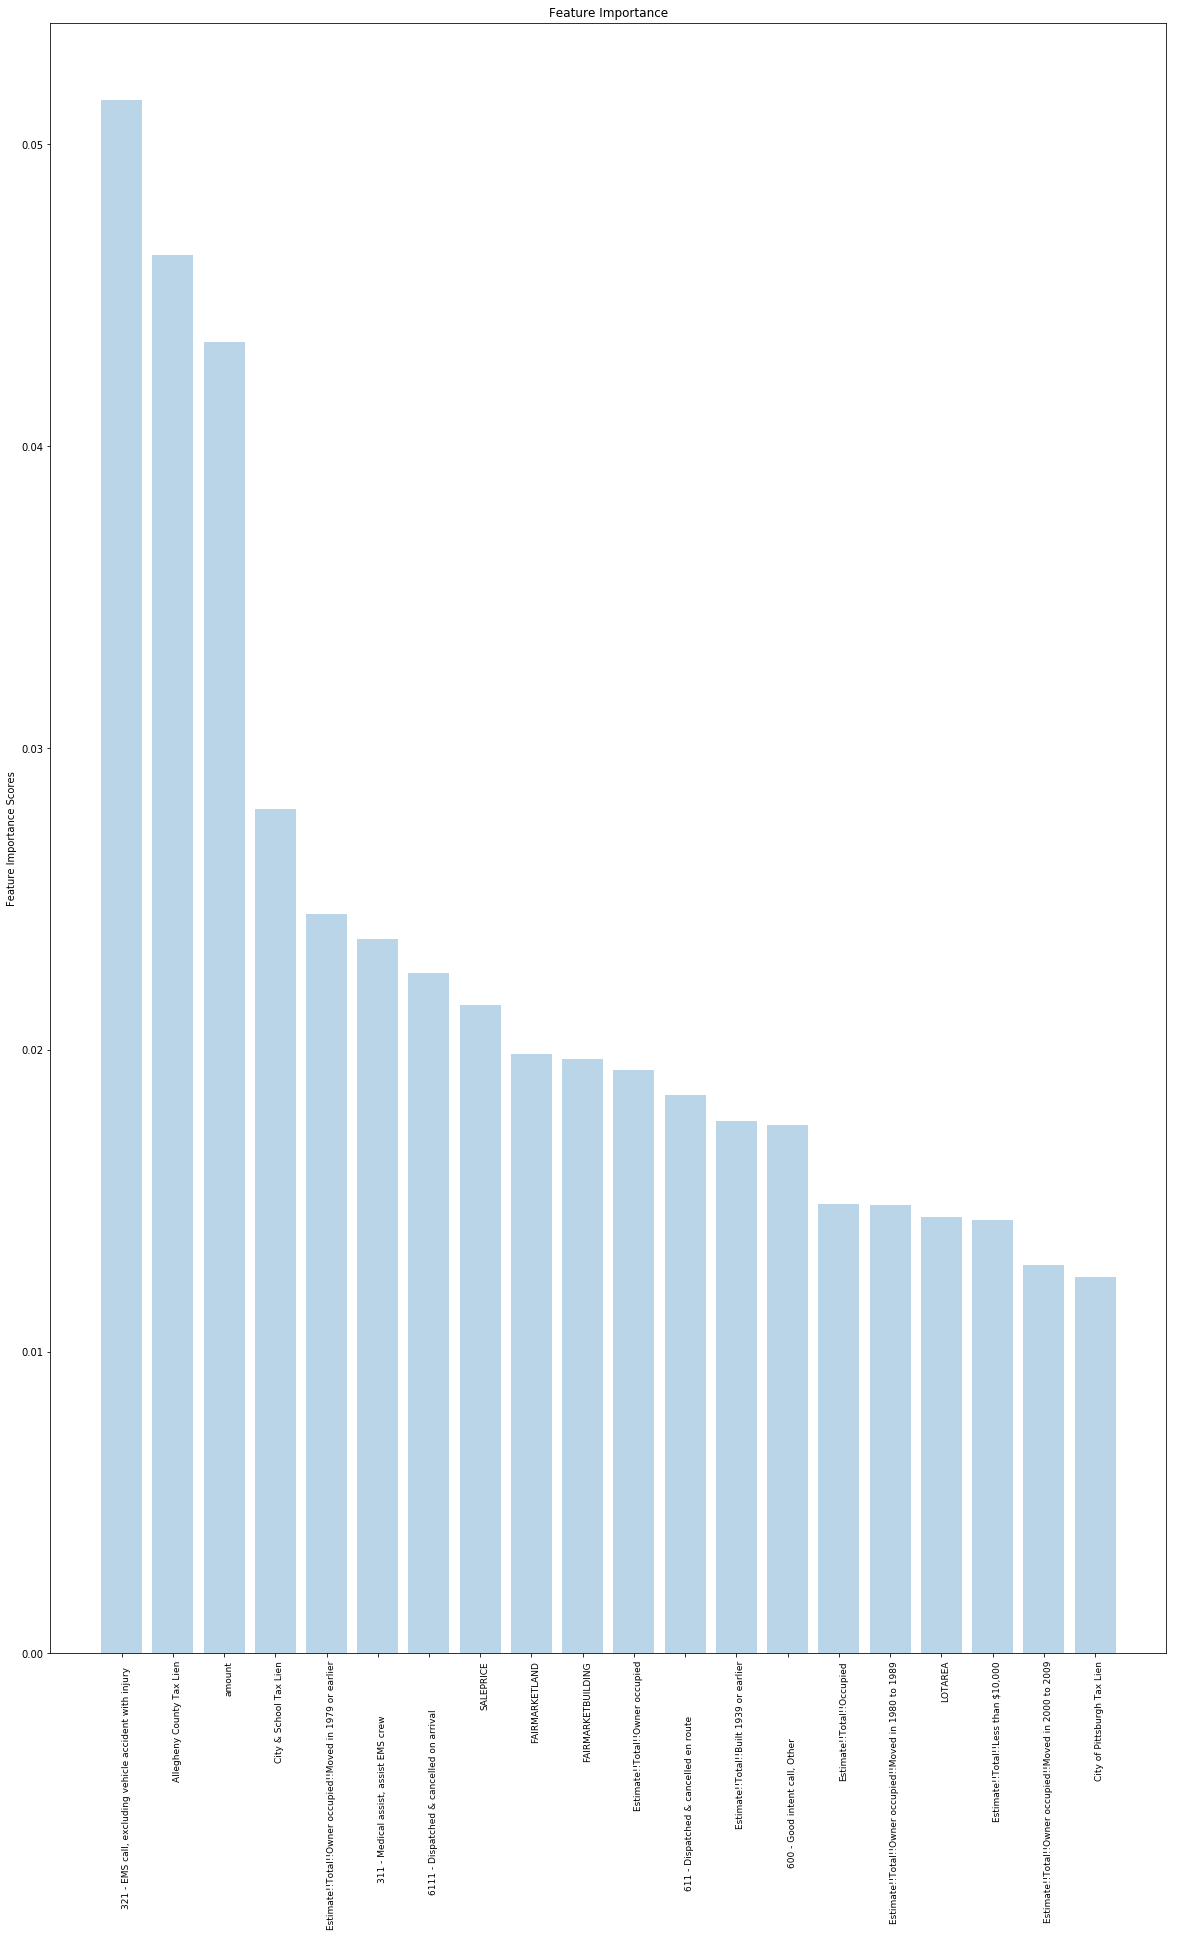

In [59]:
# Plotting the top 20 features
y_pos = np.arange(len(important_features.index[0:20]))
plt.figure(figsize=(20,30))
plt.bar(y_pos,important_features.values[0:20], alpha=0.3)
plt.xticks(y_pos, important_features.index[0:20], rotation = (90),fontsize = 9, ha='left')
plt.ylabel('Feature Importance Scores')
plt.title('Feature Importance')

features_png = "{0}FeatureImportancePlot_{1}.png".format(png_path, datetime.datetime.now().strftime('%m%d-%H%M%S'), 'a')
plt.savefig(features_png, dpi=150)
plt.show()

# Write model performance to log file:
log_path = os.path.join(curr_path, "log/")
important_features[0:50].to_csv('{0}FeatureImportanceList_{1}.csv'.format(log_path, datetime.datetime.now().strftime('%m%d-%H%M%S')), 'a')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=1,
            oob_score=False, random_state=27, verbose=0, warm_start=False)


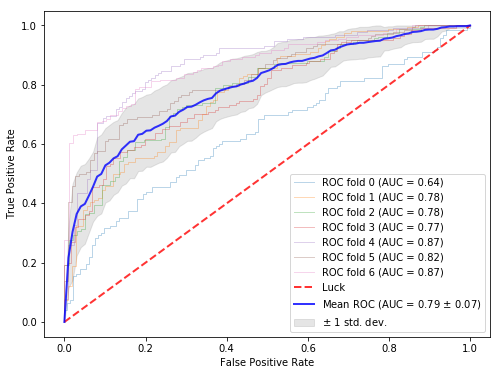

In [58]:
# plot ROC curve
from scipy import interp
d=0

print(tuned_model)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# 7-fold time series cv because training data contains 8 years of records.
tscv =TimeSeriesSplit(n_splits=7) 
# cv = KFold(n_splits=10)
i = 0
plt.figure(figsize=(8,6))
for train, test in tscv.split(select_X_train, y_train):
    probas_ = tuned_model.fit(select_X_train[train], y_train[train]).predict_proba(select_X_train[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y_train[test], probas_[:,1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
roc_png = "{0}roc_{1}.png".format(png_path, datetime.datetime.now().strftime('%m%d-%H%M%S'), 'a')
plt.savefig(roc_png)
plt.show()